Промышленность. Постановка задачи.
---

Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

План решения задачи
---

Обработка данных:

- загрузка основных библиотек для работы с данными. Используем библиотеки pandas и numpy.
- загрузка данных из файла;
- анализ данных, выявление целевого признака, анализ производственного процесса.

Подготовка данных:

- Объединение таблиц для удобства обработки по ключевому значению key;
- Удаление лишних признаков, компоновка значений;
- Удаление пропусков;
- Поиск и удаление аномалий с помощью машинного обучения.

Построение модели:

- разделение данных на тренировочную, тестовую и валидационную выборки;
- обучение разных моделей;
- предсказания на тестовых выборках;
- кросс-валидация для улучшения результата, выбор лучшей модели

Дополнительное задание.


Оглавление
---

##### Часть 1. Предварительная обработка данных:
* [1.1. Элекроэнергия, затрачиваемая на нагрев.](#1-bullet)
* [1.2. Примеси, добавляемые в сталь для изменения химического состава.](#2-bullet)
* [1.3. Инертный газ для продува стали.](#3-bullet)
* [1.4. Измерения температуры стали.](#4-bullet)
* [1.5. Проволока, подаваемая через трайб-аппарат.](#5-bullet)

##### Часть 2. Анализ данных:
* [2.1. Объединение таблиц.](#6-bullet)
* [2.2. Удаление пустых значений.](#7-bullet)
* [2.3. Поиск и удаление аномалий.](#8-bullet)
* [2.4. Переименование столбцов и разделение данных на выборки.](#9-bullet)

##### Часть 3. Построение модели:
* [3.1. Линейная регрессия.](#10-bullet)
* [3.2. LightGBM.](#11-bullet)
* [3.3. CatBoost.](#12-bullet)
* [3.4. Random Forest + Grid Search..](#13-bullet)
* [3.5. XGBoost.](#14-bullet)


##### Часть 4. Заключение. 
* [5.1. Описание шагов проекта.](#15-bullet)
* [5.2. Дополнительное задание.](#16-bullet)
* [5.3. Общий вывод.](#17-bullet)


### Загрузка библиотек

In [1]:
# обработка и отображение данных
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.polynomial.polynomial import polyfit
import warnings
warnings.filterwarnings("ignore")

# машинное обучение
from pyod.models.knn import KNN 
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import xgboost as xgb

### Загрузка данных

In [2]:
# загрузка данных
arc = pd.read_csv('/datasets/final_steel/data_arc.csv') #данные об электроэнергии, затрачиваемой на нагрев;
bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv') #данные о подаче сыпучих материалов (объём);
bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')  #данные о подаче сыпучих материалов (время);
gas = pd.read_csv('/datasets/final_steel/data_gas.csv')  #данные о продувке сплава газом;
temp = pd.read_csv('/datasets/final_steel/data_temp.csv')  #результаты измерения температуры;
wire = pd.read_csv('/datasets/final_steel/data_wire.csv')  #данные о проволочных материалах (объём);
wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')  #данные о проволочных материалах (время).

### Часть 1. Предварительная обработка данных

####  1.1. Элекроэнергия, затрачиваемая на нагрев.
<a id='1-bullet'></a>

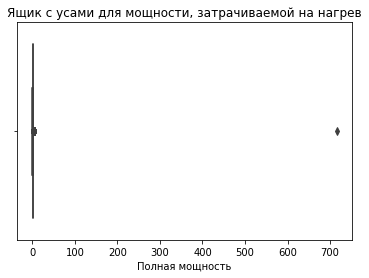

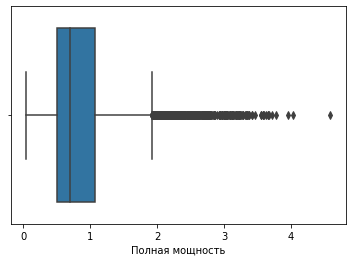

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность,tg_phi,Время нагрева
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639,0.703937,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010,0.645830,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038,0.670110,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470,0.640408,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239,0.598188,148.0
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043,0.521549,0.646124,137.0
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914,1.574162,0.688756,338.0
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281,0.577638,0.622544,126.0
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874,0.975867,0.624438,210.0
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494,1.256527,0.632261,280.0


Количество образцов в партии 14875


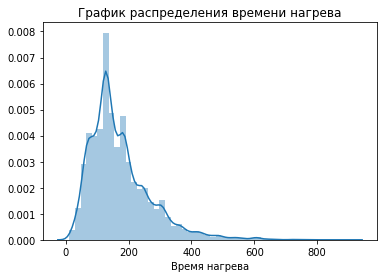

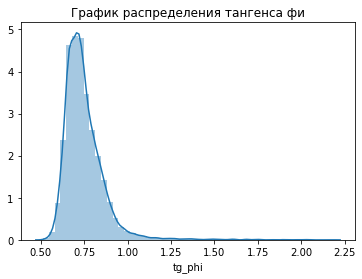

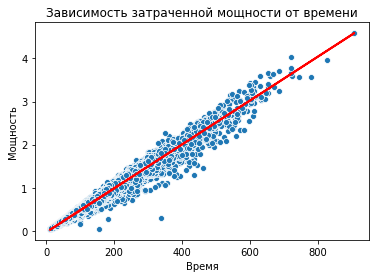

In [3]:
# расчет полной мощности S^2 = P^2 + Q^2 и тангенса фи (тангенс фи - отношение реактивной мощности к активной).
arc['Полная мощность'] = np.sqrt(arc['Активная мощность']**2 + arc['Реактивная мощность']**2)
arc['tg_phi'] =  arc['Реактивная мощность'] / arc['Активная мощность']
# расчет времени нагрева в секундах
arc['Время нагрева'] = pd.to_datetime(arc['Конец нагрева дугой']) - pd.to_datetime(arc['Начало нагрева дугой'])
arc['Время нагрева']= arc['Время нагрева'] / np.timedelta64(1, 's')
# смотрим на данные 
plt.title('Ящик с усами для мощности, затрачиваемой на нагрев')
sns.boxplot(arc['Полная мощность'])
plt.show()
# избавляемся от выбросов
arc = arc[arc['Полная мощность'] < 100]
sns.boxplot(arc['Полная мощность'])
plt.show() 
# отображение данных
display(arc.head(10))
print('Количество образцов в партии', arc['key'].count())
plt.title('График распределения времени нагрева')
sns.distplot(arc['Время нагрева'])
plt.show()

plt.title('График распределения тангенса фи')
sns.distplot(arc['tg_phi'])
plt.show()

# при tgф>1 потребитель потребляет реактивную мощность (индуктивный характер, характерный для плавки стали дугой).
plt.title('Зависимость затраченной мощности от времени')
sns.scatterplot(arc['Время нагрева'], arc['Полная мощность'])
b, m = polyfit(arc['Время нагрева'], arc['Полная мощность'], 1)
plt.plot(arc['Время нагрева'], b + m *arc['Время нагрева'], '-',linewidth=2, color='red')
plt.xlabel('Время')
plt.ylabel('Мощность')
plt.show()

#### Вывод:
Мощность подаваемая на электроды, прямо пропорционально времени применения этой мощности.
Нас, в большей степени, не интересует время нагрева - важнее отслеживать затраченную электроэнергию, так как она является целевым признаком, потребление которого необходимо снизить.

Вероятно, нам необходимо определить, при каком химическом составе температуры плавления, а следовательно, затраты электроэнергии на нагрев, будут наименьшими.

Определим сколько суммарно электроэнергии и времени нагрева затрачено на каждую партию.

Также вычислим средний tg phi для каждой партии.

In [4]:
arc_grouped = arc.pivot_table(index='key', values=['Полная мощность','Время нагрева','tg_phi'],
                              aggfunc = {'Полная мощность':'sum',
                                         'Время нагрева':'sum', 'tg_phi':'mean'})
arc_new = arc.pivot_table(index='key', values=['Полная мощность','Время нагрева','tg_phi'],
                              aggfunc = {'Полная мощность':'sum',
                                         'Время нагрева':'sum', 'tg_phi':'count'})

arc_grouped['count'] = arc_new['tg_phi']
display(arc_grouped)

,tg_phi,Время нагрева,Полная мощность,count
key,,,,
1,0.651695,1098.0,5.826395,5
2,0.645465,811.0,3.649216,4
3,0.631751,655.0,2.989534,5
4,0.641443,741.0,3.814962,4
5,0.676904,869.0,4.035758,4
...,...,...,...,...
3237,0.724274,909.0,4.844982,5
3238,0.798540,546.0,2.696542,3
3239,0.670644,1216.0,5.611883,8


####  1.2. Примеси, добавляемые в сталь для изменения химического состава
<a id='2-bullet'></a>

In [5]:
bulk.rename(columns={c: str(c) for c in bulk.columns}, inplace=True)
bulk.columns = [col.replace(' ','_') for col in bulk.columns]
bulk_time.rename(columns={c: str(c) for c in bulk_time.columns}, inplace=True)
bulk_time.columns = [col.replace(' ','_') for col in bulk_time.columns]
   
display(bulk.head(5))
display(bulk_time.head(5))

,key,Bulk_1,Bulk_2,Bulk_3,Bulk_4,Bulk_5,Bulk_6,Bulk_7,Bulk_8,Bulk_9,Bulk_10,Bulk_11,Bulk_12,Bulk_13,Bulk_14,Bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


,key,Bulk_1,Bulk_2,Bulk_3,Bulk_4,Bulk_5,Bulk_6,Bulk_7,Bulk_8,Bulk_9,Bulk_10,Bulk_11,Bulk_12,Bulk_13,Bulk_14,Bulk_15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


### ВЫВОД:
в каждую партию в определенное время добавляли несколько примесей. Пустые значения означают, что в конкретный образец именну эту примесь не добавляли. Вполне логично заменить их нулями.

На графиках ниже попробуем отследить частоту использования разных примесей ,чтобы оценить их степень влияния на химический состав изготавливаемой стали.

Практического смысла эти графики не несут, но можно визуально оценить средний объем примеси и частоту применения.

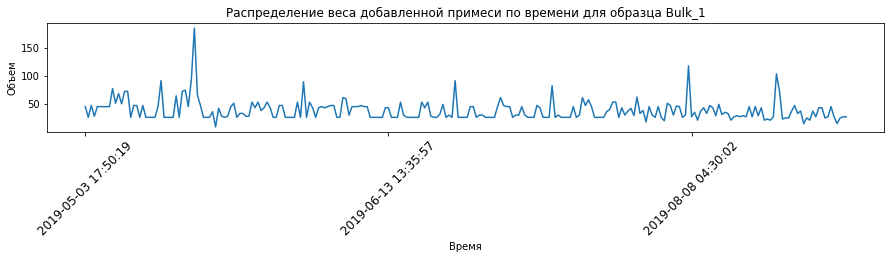

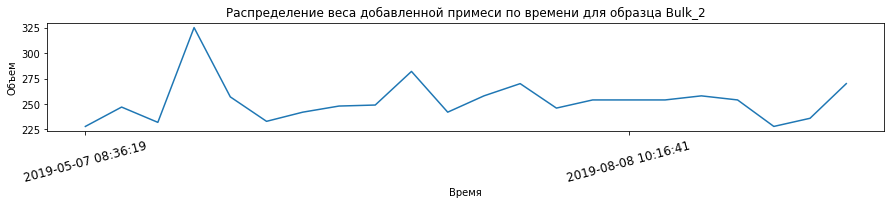

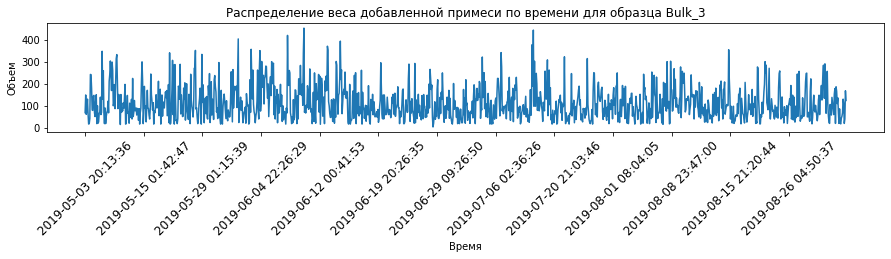

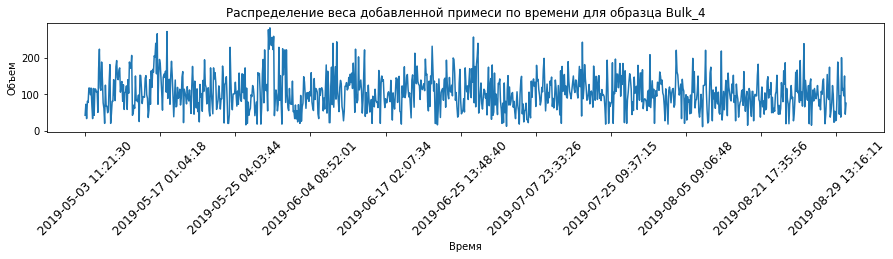

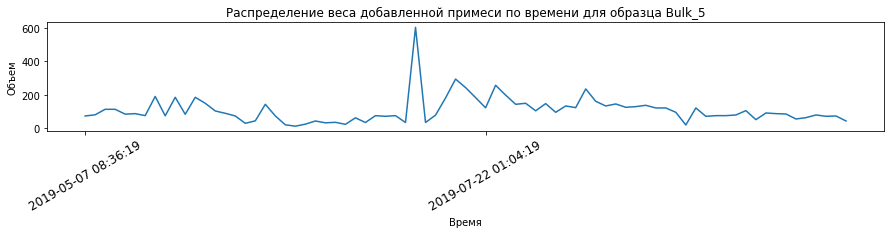

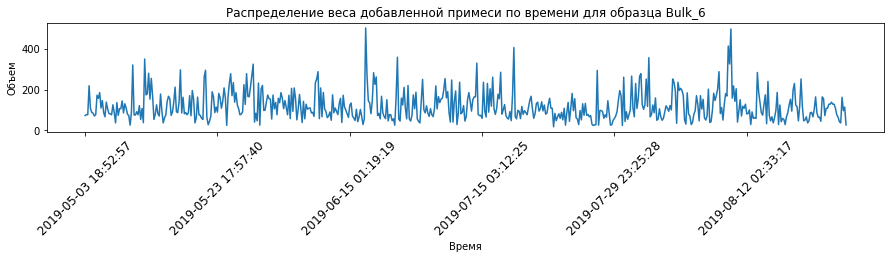

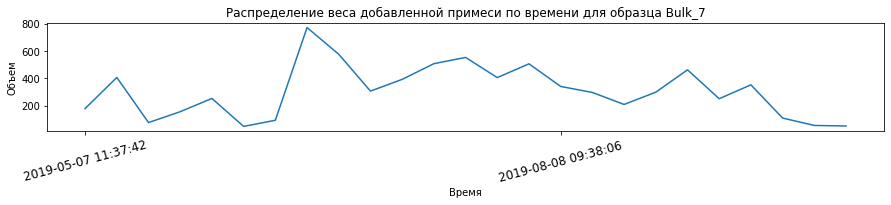

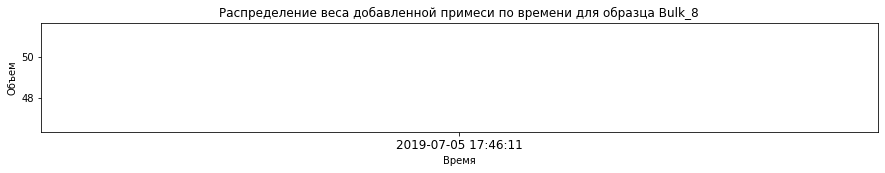

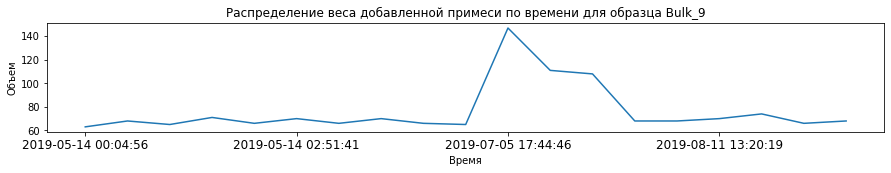

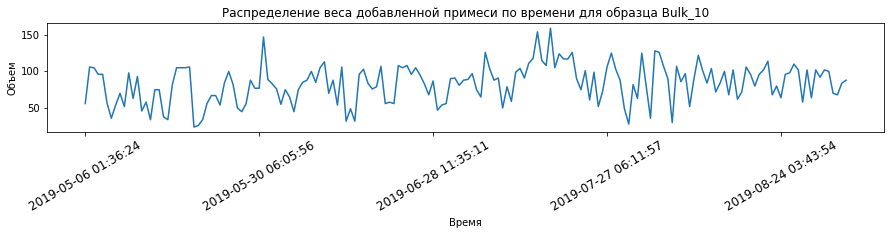

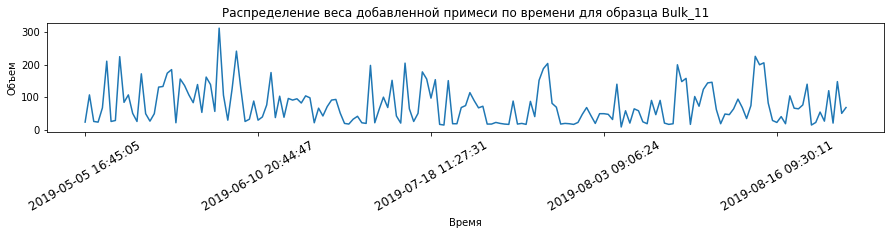

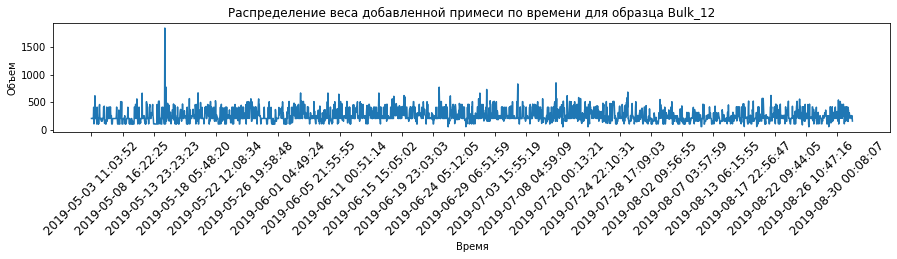

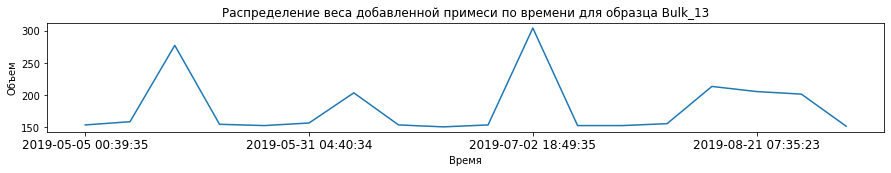

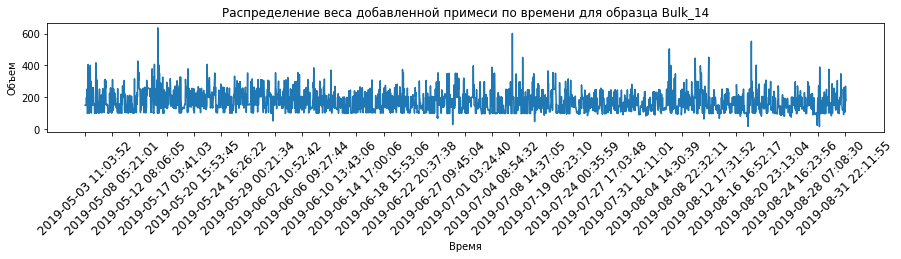

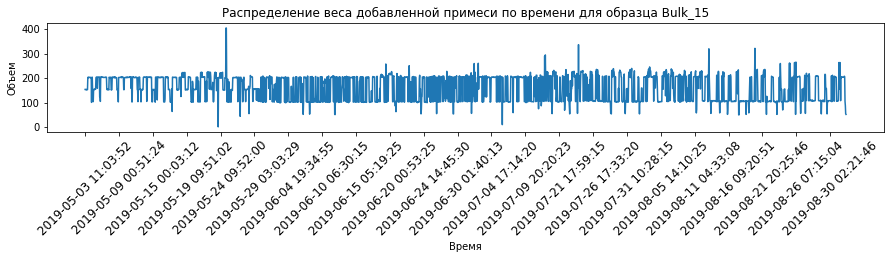

In [6]:
# создаем переменные для каждого вида примеси и добавляем в эту переменнную датафрейм с датой и объемом добавленной примеси
for i in bulk.columns[1:]:
    locals()[str(i)] = pd.DataFrame()
    locals()[str(i)]['bulk'] = bulk[i]
    locals()[str(i)]['time'] = bulk_time[i]
    locals()[str(i)]['key'] = bulk['key']
    locals()[str(i)].dropna(inplace=True)
    
    plt.figure(figsize=(15,2))
    plt.ylabel('Объем')
    plt.xlabel('Время')
    plt.plot(locals()[str(i)].time,locals()[str(i)].bulk)
    if len(locals()[str(i)]) > 200:
        plt.xticks(locals()[str(i)].time[::100],rotation = 45,fontsize = 12 )
    elif len(locals()[str(i)]) > 50:
        plt.xticks(locals()[str(i)].time[::40],rotation = 30,fontsize = 12 )
    elif len(locals()[str(i)]) > 20:
        plt.xticks(locals()[str(i)].time[::15],rotation = 15,fontsize = 12 )
    else:
        plt.xticks(locals()[str(i)].time[::5],rotation = 0,fontsize = 12 )
    plt.title('Распределение веса добавленной примеси по времени для образца {}'.format(bulk[i].name))
plt.show()

####  1.3. Инертный газ для продува стали.
<a id='3-bullet'></a>

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: Газ 1, dtype: float64


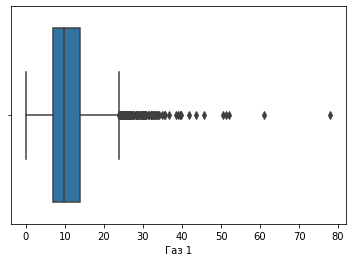

In [7]:
display(gas.head())
print((gas['Газ 1'].describe()))
sns.boxplot(gas['Газ 1'])
plt.show()

__Вывод__: ничего необычного в этих данных нет. Несколько выбросов, но от них мы избавимся позже. Медианное значения около 10.

####  1.4. Измерения температуры стали.
<a id='4-bullet'></a>

In [8]:
# изучим пропуски в данных
print(temp.isna().sum())
display(temp.tail(20))

key                0
Время замера       0
Температура     2901
dtype: int64


,key,Время замера,Температура
15887,3239,2019-09-01 01:42:46,NaN
15888,3239,2019-09-01 01:48:00,NaN
15889,3239,2019-09-01 01:59:27,NaN
15890,3239,2019-09-01 02:13:30,NaN
15891,3239,2019-09-01 02:22:15,NaN
15892,3239,2019-09-01 02:23:02,NaN
15893,3239,2019-09-01 02:24:15,NaN
15894,3240,2019-09-01 02:39:01,1617.0
15895,3240,2019-09-01 02:48:33,NaN
15896,3240,2019-09-01 03:03:21,NaN


#### Вывод:
В таблице измерений температуры много пропущенных значений.
Присутствуют образцы с лишь одним измерением температуры.
Такие измерения нам ни о чем не скажут, поэтому удалим пропущенные значения в измерениях температуры, а также образцы с лишь одним измерением

In [9]:
# удаляем пропуски
temp.dropna(inplace=True)
# создаем пустые списки, добавляем в них максимальные и минимальные значения времени и температуры для каждого образца
time_max = []
time_min = []
temp_min=[]
temp_max=[]
key=[]
for i in temp['key'].unique():
    time_max.append(temp[temp['key'] == i]['Время замера'].max())
    time_min.append(temp[temp['key'] == i]['Время замера'].min())
    temp_max.append(temp[temp['key'] == i]['Температура'].max())
    temp_min.append(temp[temp['key'] == i]['Температура'].min())
    key.append(int(i))
    
# создаем пустой датафрейм ,добавляем в него полученные значения, 
# а также считаем разницы во времени и температуры между первым и последним измерением
temp_new = pd.DataFrame()
temp_new['key']=key
temp_new['time_max']=time_max
temp_new['time_min']=time_min
temp_new['temp_min'] =temp_min
temp_new['temp_max'] =temp_max
temp_new['time_diff'] = (pd.to_datetime(temp_new['time_max']) - pd.to_datetime(temp_new['time_min']))/ np.timedelta64(1, 's')
temp_new['temp_diff'] = temp_new['temp_max'] - temp_new['temp_min']

# удаляем образцы, в которых разница между температурой или измерениями равна нулю.
temp_new = temp_new[temp_new['temp_diff'] !=0]

# определим относительную скорость изменения температуры в единицу времени как показатель теплопроводности конечного материала
# как отношение изменения температуры за временной период
temp_new['t_delta'] = temp_new['temp_diff'] / temp_new['time_diff']
display(temp_new)

,key,time_max,time_min,temp_min,temp_max,time_diff,temp_diff,t_delta
0,1,2019-05-03 11:30:39,2019-05-03 11:16:18,1571.0,1618.0,861.0,47.0,0.054588
1,2,2019-05-03 11:59:12,2019-05-03 11:37:27,1577.0,1608.0,1305.0,31.0,0.023755
2,3,2019-05-03 12:34:57,2019-05-03 12:13:17,1596.0,1599.0,1300.0,3.0,0.002308
3,4,2019-05-03 12:59:25,2019-05-03 12:52:57,1601.0,1625.0,388.0,24.0,0.061856
4,5,2019-05-03 13:36:01,2019-05-03 13:23:19,1576.0,1602.0,762.0,26.0,0.034121
...,...,...,...,...,...,...,...,...
2472,2495,2019-08-06 00:54:42,2019-08-06 00:35:45,1570.0,1591.0,1137.0,21.0,0.018470
2473,2496,2019-08-06 01:29:52,2019-08-06 01:02:54,1554.0,1595.0,1618.0,41.0,0.025340
2474,2497,2019-08-06 01:53:50,2019-08-06 01:41:53,1571.0,1589.0,717.0,18.0,0.025105
2475,2498,2019-08-06 02:25:31,2019-08-06 02:03:49,1570.0,1594.0,1302.0,24.0,0.018433


####  1.5. Проволока, подаваемая через трайб-аппарат.
<a id='5-bullet'></a>

In [10]:
display(wire.head())
display(wire_time.head())

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


__Вывод__: эти данные используются аналогично примесям.

### Вывод по 1 части:
Рассмотрены все имеющиеся данные.

Удалены пропуски в измерениях температуры, т.к. температура это целевой признак.

Пропуски в сыпучих добавках и проволоке удалять не нужно, так как каждый тип проволоки может быть добавлен в одну партия в разных количествах, а может быть не добавлен вовсе. Все NaN в этих таблицах можно заменить нулями, что мы сделаем на следующем этапе.

Затем объединим все данные в одну таблицу по номеру партии и подготовим данными для машинного обучения.

Целевым признаком в модели является температура - её мы и будем предсказывать.

Время добавления проволоки и сыпучих добавок предлагается отбросить. Важен только объем примесей для определения конечного химического состава.

### Часть 2. Анализ данных.

####  2.1. Объединение таблиц.
<a id='6-bullet'></a>

Объединим все таблицы в одну по ключевому значению: номер партии. Целевым признаком будет температура.

In [11]:
temp_total= temp_new[['key','temp_min','temp_max','time_diff']]
total = arc_grouped.merge(temp_total, how='outer', on='key')
total = total.merge(bulk, how='outer', on='key')
total = total.merge(wire, how='outer', on='key')
total = total.merge(gas, how='outer', on='key')
display(len(total))

3241

####  2.2. Удаление пустых значений.
<a id='7-bullet'></a>

Поскольку температура является целевым признаком, удалим все строки после объединения, где температура равна NaN.
Мы предположили, что значения NaN при подаче в сталь инородного материала, означают, что материал не был подан. Поэтому заменим все остальные NaN на нули

In [12]:
total = total[total['temp_max'].notna()]
total.fillna(0, inplace=True)

####  2.3. Поиск и удаление аномалий.
<a id='8-bullet'></a>

In [13]:
def outliers(data):
    print('Количество наблюдений', len(data))
    model = KNN()
    model.fit(data) 
    estimation_knn = model.predict(data)== 1
    outliers_knn = estimation_knn.sum()
    print("Количество аномалий (KNN): ", outliers_knn)
    model = IsolationForest(n_estimators=50,random_state=12345)

    estimation_iforest = model.fit_predict(data) == -1
    outliers_iforest = estimation_iforest.sum()
    print("Количество аномалий (изоляционный лес): ", outliers_iforest)

    data_new = data.copy()
    data_new.reset_index(inplace=True,drop=True)
    outliers = pd.Series(np.array(estimation_knn | estimation_iforest))
    data_new['outliers'] = outliers
    data_new = data_new[data_new['outliers'] != True]
    data_new = data_new.drop(columns=['outliers'])
    return data_new
total_clean = outliers(total)

Количество наблюдений 2472
Количество аномалий (KNN):  221
Количество аномалий (изоляционный лес):  248


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Принято решение удалить аномалии, выявленные обеими способами.
Выведем на экран конечную длину массиву данных.

In [14]:
print(len(total_clean))
display(total_clean)

2116


,key,tg_phi,Время нагрева,Полная мощность,count,temp_min,temp_max,time_diff,Bulk_1,Bulk_2,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Газ 1
0,1,0.651695,1098.0,5.826395,5.0,1571.0,1618.0,861.0,0.0,0.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986
1,2,0.645465,811.0,3.649216,4.0,1577.0,1608.0,1305.0,0.0,0.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
2,3,0.631751,655.0,2.989534,5.0,1596.0,1599.0,1300.0,0.0,0.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793
3,4,0.641443,741.0,3.814962,4.0,1601.0,1625.0,388.0,0.0,0.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219
4,5,0.676904,869.0,4.035758,4.0,1576.0,1602.0,762.0,0.0,0.0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2467,2495,0.731065,723.0,3.986869,4.0,1570.0,1591.0,1137.0,0.0,0.0,...,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.125735
2468,2496,0.672407,940.0,5.057033,6.0,1554.0,1595.0,1618.0,0.0,0.0,...,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.412616
2469,2497,0.839576,569.0,2.885017,3.0,1571.0,1589.0,717.0,0.0,0.0,...,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.271699
2470,2498,0.681031,750.0,4.143749,5.0,1570.0,1594.0,1302.0,0.0,0.0,...,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.953657


####  2.4. Переименование столбцов и разделение данных на выборки.
<a id='9-bullet'></a>

In [15]:
total_clean.columns = ['key', 'tg_phi', 'heat_time', 'full_power','count', 'temp_min',
       'temp_max', 'time_diff', 'Bulk_1', 'Bulk_2', 'Bulk_3', 'Bulk_4',
       'Bulk_5', 'Bulk_6', 'Bulk_7', 'Bulk_8', 'Bulk_9', 'Bulk_10', 'Bulk_11',
       'Bulk_12', 'Bulk_13', 'Bulk_14', 'Bulk_15', 'Wire 1', 'Wire 2',
       'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9',
       'gas']
print(total_clean.columns)

Index(['key', 'tg_phi', 'heat_time', 'full_power', 'count', 'temp_min',
       'temp_max', 'time_diff', 'Bulk_1', 'Bulk_2', 'Bulk_3', 'Bulk_4',
       'Bulk_5', 'Bulk_6', 'Bulk_7', 'Bulk_8', 'Bulk_9', 'Bulk_10', 'Bulk_11',
       'Bulk_12', 'Bulk_13', 'Bulk_14', 'Bulk_15', 'Wire 1', 'Wire 2',
       'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9',
       'gas'],
      dtype='object')


In [16]:
X = total_clean.drop(columns=['key','temp_max'],axis=1)
y=total_clean['temp_max']

x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, random_state = 12345)
x_valid, x_test, y_valid, y_test = train_test_split(x_test,y_test, test_size = 0.5, random_state = 12345)

print(x_train.shape, x_valid.shape, x_test.shape)

(1587, 31) (264, 31) (265, 31)


In [18]:
x_train.columns

Index(['tg_phi', 'heat_time', 'full_power', 'count', 'temp_min', 'time_diff',
       'Bulk_1', 'Bulk_2', 'Bulk_3', 'Bulk_4', 'Bulk_5', 'Bulk_6', 'Bulk_7',
       'Bulk_8', 'Bulk_9', 'Bulk_10', 'Bulk_11', 'Bulk_12', 'Bulk_13',
       'Bulk_14', 'Bulk_15', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5',
       'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9', 'gas'],
      dtype='object')

### Часть 3. Построение модели.

####  3.1. Линейная регрессия.
<a id='10-bullet'></a>

In [17]:
lr = LinearRegression(normalize=True)
lr.fit(x_train, y_train)
lr_pred=lr.predict(x_valid)
print('MAE = {}'.format(mean_absolute_error(y_valid,lr_pred)))

MAE = 7.975035314717746


####  3.2. LightGBM.
<a id='11-bullet'></a>

In [54]:
lgb_model = lgb.LGBMRegressor(random_state=12345)

lgb_model.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], eval_metric='MAE', early_stopping_rounds=5)
lgb_pred=lgb_model.predict(x_test)
print('MAE = {}'.format(mean_absolute_error(y_test,lgb_pred)))

[1]	valid_0's l1: 11.9417	valid_0's l2: 236.859
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l1: 11.2404	valid_0's l2: 208.41
[3]	valid_0's l1: 10.6044	valid_0's l2: 184.965
[4]	valid_0's l1: 10.0886	valid_0's l2: 166.968
[5]	valid_0's l1: 9.63404	valid_0's l2: 151.834
[6]	valid_0's l1: 9.18976	valid_0's l2: 137.75
[7]	valid_0's l1: 8.77817	valid_0's l2: 126.329
[8]	valid_0's l1: 8.49722	valid_0's l2: 117.573
[9]	valid_0's l1: 8.18658	valid_0's l2: 109.846
[10]	valid_0's l1: 7.95171	valid_0's l2: 103.96
[11]	valid_0's l1: 7.74918	valid_0's l2: 98.8774
[12]	valid_0's l1: 7.55166	valid_0's l2: 94.1161
[13]	valid_0's l1: 7.4436	valid_0's l2: 91.2084
[14]	valid_0's l1: 7.31219	valid_0's l2: 88.3899
[15]	valid_0's l1: 7.2068	valid_0's l2: 85.9367
[16]	valid_0's l1: 7.1081	valid_0's l2: 83.6317
[17]	valid_0's l1: 7.01869	valid_0's l2: 81.7771
[18]	valid_0's l1: 6.92503	valid_0's l2: 79.9786
[19]	valid_0's l1: 6.84803	valid_0's l2: 78.5421
[20]	valid_0's l1: 6.787

####  3.3. CatBoost.
<a id='12-bullet'></a>

In [55]:
cat = CatBoostRegressor(random_state=12345, eval_metric='MAE')
cat.fit(x_train,y_train,eval_set=[(x_valid, y_valid)], verbose=True)
cat_pred=cat.predict(x_test)
print('MAE = {}'.format(mean_absolute_error(y_test,cat_pred)))

0:	learn: 12.4833832	test: 12.5030997	best: 12.5030997 (0)	total: 6.39ms	remaining: 6.38s
1:	learn: 12.2966066	test: 12.3326370	best: 12.3326370 (1)	total: 10.6ms	remaining: 5.27s
2:	learn: 12.1060391	test: 12.1465816	best: 12.1465816 (2)	total: 15.9ms	remaining: 5.28s
3:	learn: 11.9375163	test: 11.9906166	best: 11.9906166 (3)	total: 55.1ms	remaining: 13.7s
4:	learn: 11.7611195	test: 11.8286770	best: 11.8286770 (4)	total: 58.7ms	remaining: 11.7s
5:	learn: 11.5939536	test: 11.6571078	best: 11.6571078 (5)	total: 61.5ms	remaining: 10.2s
6:	learn: 11.4370694	test: 11.5061233	best: 11.5061233 (6)	total: 64.8ms	remaining: 9.19s
7:	learn: 11.2811701	test: 11.3584342	best: 11.3584342 (7)	total: 74.5ms	remaining: 9.24s
8:	learn: 11.1412164	test: 11.2258608	best: 11.2258608 (8)	total: 77.4ms	remaining: 8.52s
9:	learn: 10.9861039	test: 11.0813118	best: 11.0813118 (9)	total: 79.6ms	remaining: 7.88s
10:	learn: 10.8662408	test: 10.9601148	best: 10.9601148 (10)	total: 82.3ms	remaining: 7.4s
11:	learn

####  3.4. Random Forest + Grid Search.
<a id='13-bullet'></a>

In [56]:
param_grid = {
    'max_depth': [10, 20, 30, 40],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
}

rf = RandomForestRegressor(random_state=12345, criterion = 'mae')
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
# Fit the random search model
grid_search.fit(x_train, y_train)
print(grid_search.best_params_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] max_depth=10, max_features=2, min_samples_leaf=3, min_samples_split=8 
[CV]  max_depth=10, max_features=2, min_samples_leaf=3, min_samples_split=8, total=   0.1s
[CV] max_depth=10, max_features=2, min_samples_leaf=3, min_samples_split=8 


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  max_depth=10, max_features=2, min_samples_leaf=3, min_samples_split=8, total=   0.1s
[CV] max_depth=10, max_features=2, min_samples_leaf=3, min_samples_split=8 
[CV]  max_depth=10, max_features=2, min_samples_leaf=3, min_samples_split=8, total=   0.1s
[CV] max_depth=10, max_features=2, min_samples_leaf=3, min_samples_split=10 
[CV]  max_depth=10, max_features=2, min_samples_leaf=3, min_samples_split=10, total=   0.1s
[CV] max_depth=10, max_features=2, min_samples_leaf=3, min_samples_split=10 
[CV]  max_depth=10, max_features=2, min_samples_leaf=3, min_samples_split=10, total=   0.1s
[CV] max_depth=10, max_features=2, min_samples_leaf=3, min_samples_split=10 
[CV]  max_depth=10, max_features=2, min_samples_leaf=3, min_samples_split=10, total=   0.1s
[CV] max_depth=10, max_features=2, min_samples_leaf=3, min_samples_split=12 
[CV]  max_depth=10, max_features=2, min_samples_leaf=3, min_samples_split=12, total=   0.1s
[CV] max_depth=10, max_features=2, min_samples_leaf=3, min_samples

[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:   24.7s finished


{'max_depth': 20, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 8}


Best parameters: {'max_depth': 30, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 8}

In [57]:
rf = RandomForestRegressor(max_depth=30,min_samples_split=8,n_estimators =2000,random_state=12345)
rf.fit(x_train, y_train)
rf_preds = rf.predict(x_test)
print('MAE = {}'.format(mean_absolute_error(y_test,rf_preds)))

MAE = 6.313920559709127


####  3.5. XGBoost.
<a id='14-bullet'></a>

In [58]:
xgbr = xgb.XGBRegressor(verbosity=0, random_state=12345) 
xgbr.fit(x_train,y_train,eval_set=[(x_valid, y_valid)],verbose=True)
ypred = xgbr.predict(x_test)
mae = mean_absolute_error(y_test, ypred)
print("MAE: %.2f" % mae)

[0]	validation_0-rmse:1441.56
[1]	validation_0-rmse:1297.5
[2]	validation_0-rmse:1167.83
[3]	validation_0-rmse:1051.13
[4]	validation_0-rmse:946.09
[5]	validation_0-rmse:851.553
[6]	validation_0-rmse:766.466
[7]	validation_0-rmse:689.886
[8]	validation_0-rmse:620.964
[9]	validation_0-rmse:558.934
[10]	validation_0-rmse:503.108
[11]	validation_0-rmse:452.867
[12]	validation_0-rmse:407.653
[13]	validation_0-rmse:366.965
[14]	validation_0-rmse:330.31
[15]	validation_0-rmse:297.357
[16]	validation_0-rmse:267.715
[17]	validation_0-rmse:241.002
[18]	validation_0-rmse:216.954
[19]	validation_0-rmse:195.323
[20]	validation_0-rmse:175.823
[21]	validation_0-rmse:158.276
[22]	validation_0-rmse:142.507
[23]	validation_0-rmse:128.316
[24]	validation_0-rmse:115.549
[25]	validation_0-rmse:104.073
[26]	validation_0-rmse:93.7553
[27]	validation_0-rmse:84.4865
[28]	validation_0-rmse:76.1658
[29]	validation_0-rmse:68.6703
[30]	validation_0-rmse:62.0013
[31]	validation_0-rmse:55.9771
[32]	validation_0-rms

### Часть 4. Заключение.

__Критерии оценки__

Целевой признак: последняя измеренная температура.

Метрика: MAE

Критерии оценки:

- MAE > 8.7 — 0 sp
- 7.6 < MAE ≤ 8.7 — 4 sp
- 6.8 < MAE ≤ 7.6 — 4.5 sp
- 6.3 < MAE ≤ 6.8 — 5 sp
- 6.0 < MAE ≤ 6.3 — 5.5 sp
- MAE ≤ 6.0 — 6 sp

####  4.1. Описание шагов проекта.
<a id='15-bullet'></a>

####  4.2. Дополнительное задание.
<a id='16-bullet'></a>

Вам поручили изучить характеристики процесса обработки стали. Для каждого значения столбца key найдите:

- Длительность времени между первым и последним замером температуры.

In [59]:
extra_temp = temp_new[['key','time_diff']]
extra_temp.columns = ['key','Длительность времени между первым и последним замером температуры, с']
display(extra_temp)

,key,"Длительность времени между первым и последним замером температуры, с"
0,1,861.0
1,2,1305.0
2,3,1300.0
3,4,388.0
4,5,762.0
...,...,...
2472,2495,1137.0
2473,2496,1618.0
2474,2497,717.0
2475,2498,1302.0


- Суммарное время нагрева, то есть сумма значений по всем промежуткам между запусками нагрева электродов.

In [60]:
def convert(seconds):
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    return "%d часов %02d минут %02d секунд" % (hour, minutes, seconds)


print('Суммарное время нагрева: {} '.format(convert(arc['Время нагрева'].sum())))

Суммарное время нагрева: 13 часов 21 минут 08 секунд 


- Количество запусков нагрева электродами.

In [61]:
print('Количество запусков нагрева стали - {} раз'.format(arc.shape[0]))
print('Среднее время запуска нагрева стали - {:.2f} секунд'.format(arc['Время нагрева'].sum()/arc.shape[0]))

Количество запусков нагрева стали - 14875 раз
Среднее время запуска нагрева стали - 171.68 секунд


In [62]:
corr = arc.corr()
corr.style.background_gradient(cmap='coolwarm')

,key,Активная мощность,Реактивная мощность,Полная мощность,tg_phi,Время нагрева
key,1,-0.0213673,-0.000159274,-0.0132919,0.0882789,-0.0183407
Активная мощность,-0.0213673,1,0.963182,0.994279,-0.0357407,0.974129
Реактивная мощность,-0.000159274,0.963182,1,0.986237,0.198639,0.971269
Полная мощность,-0.0132919,0.994279,0.986237,1,0.0581752,0.981205
tg_phi,0.0882789,-0.0357407,0.198639,0.0581752,1,0.0666902
Время нагрева,-0.0183407,0.974129,0.971269,0.981205,0.0666902,1


- Среднее соотношение потребления активной и реактивной мощности.

Такое соотношение характеризуется тангенсом угла phi (угол между активной и полной мощностями).

In [63]:
print('Среднее соотношение потребления активной и реактивной мощности равно {:.2f}'.format(arc['tg_phi'].mean()))

Среднее соотношение потребления активной и реактивной мощности равно 0.75


- По всем полученным столбцам вычислите статистики: средние, минимальные и максимальные значения, медиану и величины 25%- и 75%-квартилей.

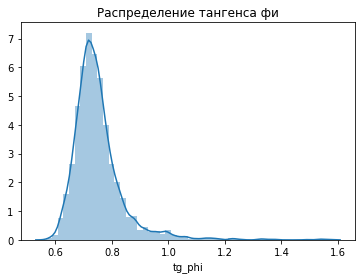

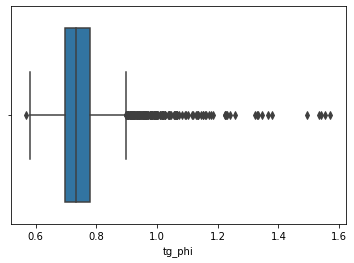

count    3214.000000
mean        0.750244
std         0.091531
min         0.568125
25%         0.698295
50%         0.734078
75%         0.777677
max         1.570969
Name: tg_phi, dtype: float64


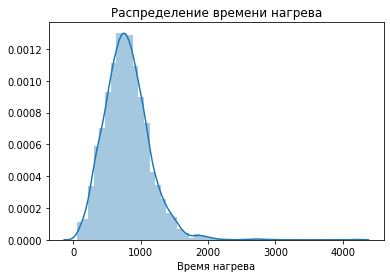

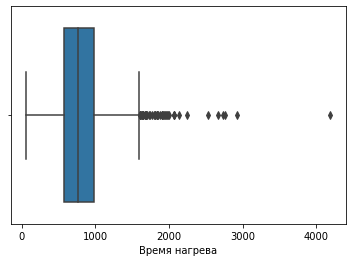

count    3214.000000
mean      794.545115
std       332.491076
min        57.000000
25%       571.000000
50%       770.000000
75%       983.000000
max      4189.000000
Name: Время нагрева, dtype: float64


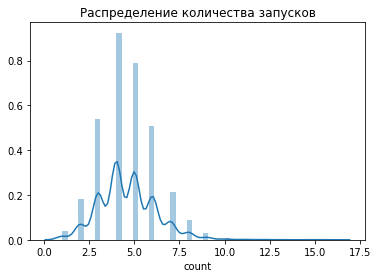

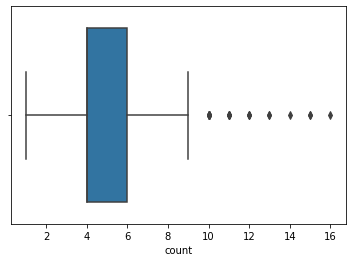

count    3214.000000
mean        4.628189
std         1.608866
min         1.000000
25%         4.000000
50%         4.000000
75%         6.000000
max        16.000000
Name: count, dtype: float64


In [64]:
plt.title('Распределение тангенса фи')
sns.distplot(arc_grouped['tg_phi'])
plt.show()

sns.boxplot(arc_grouped['tg_phi'])
plt.show()
print(arc_grouped['tg_phi'].describe())

plt.title('Распределение времени нагрева')
sns.distplot(arc_grouped['Время нагрева'])
plt.show()

sns.boxplot(arc_grouped['Время нагрева'])
plt.show()
print(arc_grouped['Время нагрева'].describe())

plt.title('Распределение количества запусков')
sns.distplot(arc_grouped['count'])
plt.show()

sns.boxplot(arc_grouped['count'])
plt.show()
print(arc_grouped['count'].describe())

####  4.3. Общий вывод.
<a id='17-bullet'></a>

### Сравнение моделей
<table>
  <tr>
    <th>Название модели</th>
    <td>MAE на валидационной выборке</td>
    <td>MAE на тестовой выборке</td>      
  </tr>
  <tr>
    <th>Линейная регрессия</th>
    <td>--</td>
    <td>7.97</td>
  </tr>
  <tr>
    <th>LGBM</th>
    <td>6.20</td>
    <td>6.25</td>
  </tr>
  <tr>
    <th>CatBoost</th>
    <td>5.98</td>
    <td>5.91</td>
  </tr>
    <tr>
    <th>Random Forest (СV)</th>
    <td>--</td>
    <td>6.31</td>
  </tr>
  </tr>
    <tr>
    <th>XGBoost</th>
    <td>8.30</td>
    <td>6.51</td>
  </tr>
</table>

Наилучшие результаты даёт модель CatBoost. Только на ней удалось достичь требуемого параметра MAE < 6.
 
В таблице ниже приведены наиболее важные параметры при обучении модели.

In [65]:
features = pd.Series(cat.feature_importances_)
columns = pd.Series(total_clean.columns.values)
importances = (pd.concat([columns,features], axis=1))
importances.columns = ['feature', 'importance']
display(importances[importances['importance'] > 5])

,feature,importance
1,tg_phi,6.402744
2,heat_time,8.636182
4,count,36.418717
5,temp_min,15.056620
21,Bulk_14,9.239714


Отчет по решению
---

В отчёте ответьте на вопросы:
- Какие пункты плана были выполнены, а какие — нет (поясните почему)?

Выполнены все пункты плана. Разобран производственный процесс, выявлен целеврй признак в виде конечной температуры для каждой партии. Поставлена задача - прогноз этой температуры на основе добавленных примесей и прочих компонент.
Возможностьб экономиии электроэнергии состоит в поиске оптимального состава примесей в стали, при котором нагрев будет происходить при минимальных затратах электроэнергии.
Не на всех моделях выполненна кросс-валидация и гри сёрч, так как удовлетворительные результаты получены при параметрах по умолчанию. Принято решение оптимизировать время решения задачи.

- Какие трудности возникли и как вы их преодолели?

Изначально появилась трудность в достижении требуемого уровня погрешности пр прогнозе температуры, но при повторном изучении признаков было выявлено, что на изменение температуря влияет не только общее время нагрева, а также и количество запусков нагрева. После добавления этого признака задача была решена.

- Какие ключевые шаги в решении задачи выделили?

Подготовка данных, удаление аномалий и добавление новых комплексных признаков, образованных от сочетания исходных.

- Какая ваша итоговая модель и какое у неё качество?

<table>
  <tr>
    <th>Название модели</th>
    <td>MAE на валидационной выборке</td>
    <td>MAE на тестовой выборке</td>      
  </tr>
  <tr>
    <th>Линейная регрессия</th>
    <td>--</td>
    <td>7.97</td>
  </tr>
  <tr>
    <th>LGBM</th>
    <td>6.20</td>
    <td>6.25</td>
  </tr>
  <tr>
    <th>CatBoost</th>
    <td bgcolor="#00FF66">5.98</td>
    <td bgcolor="#00FF66">5.91</td>
  </tr>
    <tr>
    <th>Random Forest (СV)</th>
    <td>--</td>
    <td>6.31</td>
  </tr>
  </tr>
    <tr>
    <th>XGBoost</th>
    <td>8.30</td>
    <td>6.51</td>
  </tr>
</table>

Лучшая модель - CatBoost.